<a href="https://colab.research.google.com/github/crcrpar/SpectralNormalization/blob/master/sngan_cifar_10_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import Foundation
import TensorFlow

#if canImport(FoundationNetworking)
    import FoundationNetworking
#endif

import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let matplotlib = Python.import("matplotlib")
let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")

# 1. CIFAR Data Loading

From https://github.com/tensorflow/swift-models/blob/08c80a5d797ed771df899169914f84d8dcaa9eec/CIFAR/Data.swift

In [0]:
func downloadCIFAR10IfNotPresent(to directory: String = ".") {
    let downloadPath = "\(directory)/cifar-10-batches-bin"
    let directoryExists = FileManager.default.fileExists(atPath: downloadPath)

    guard !directoryExists else { return }

    print("Downloading CIFAR dataset...")
    let archivePath = "\(directory)/cifar-10-binary.tar.gz"
    let archiveExists = FileManager.default.fileExists(atPath: archivePath)
    if !archiveExists {
        print("Archive missing, downloading...")
        do {
            let downloadedFile = try Data(
                contentsOf: URL(
                    string: "https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz")!)
            try downloadedFile.write(to: URL(fileURLWithPath: archivePath))
        } catch {
            print("Could not download CIFAR dataset, error: \(error)")
            exit(-1)
        }
    }

    print("Archive downloaded, processing...")

    #if os(macOS)
        let tarLocation = "/usr/bin/tar"
    #else
        let tarLocation = "/bin/tar"
    #endif

    let task = Process()
    task.executableURL = URL(fileURLWithPath: tarLocation)
    task.arguments = ["xzf", archivePath]
    do {
        try task.run()
        task.waitUntilExit()
    } catch {
        print("CIFAR extraction failed with error: \(error)")
    }

    do {
        try FileManager.default.removeItem(atPath: archivePath)
    } catch {
        print("Could not remove archive, error: \(error)")
        exit(-1)
    }

    print("Unarchiving completed")
}

struct Example: TensorGroup {
    var label: Tensor<Int32>
    var data: Tensor<Float>

    init(label: Tensor<Int32>, data: Tensor<Float>) {
        self.label = label
        self.data = data
    }

    public init<C: RandomAccessCollection>(
        _handles: C
    ) where C.Element: _AnyTensorHandle {
        precondition(_handles.count == 2)
        let labelIndex = _handles.startIndex
        let dataIndex = _handles.index(labelIndex, offsetBy: 1)
        label = Tensor<Int32>(handle: TensorHandle<Int32>(handle: _handles[labelIndex]))
        data = Tensor<Float>(handle: TensorHandle<Float>(handle: _handles[dataIndex]))
    }
}

func loadCIFARFile(named name: String, in directory: String = ".") -> Example {
    downloadCIFAR10IfNotPresent(to: directory)
    let path = "\(directory)/cifar-10-batches-bin/\(name)"

    let imageCount = 10000
    guard let fileContents = try? Data(contentsOf: URL(fileURLWithPath: path)) else {
        print("Could not read dataset file: \(name)")
        exit(-1)
    }
    guard fileContents.count == 30_730_000 else {
        print(
            "Dataset file \(name) should have 30730000 bytes, instead had \(fileContents.count)")
        exit(-1)
    }

    var bytes: [UInt8] = []
    var labels: [Int64] = []

    let imageByteSize = 3073
    for imageIndex in 0..<imageCount {
        let baseAddress = imageIndex * imageByteSize
        labels.append(Int64(fileContents[baseAddress]))
        bytes.append(contentsOf: fileContents[(baseAddress + 1)..<(baseAddress + 3073)])
    }

    let labelTensor = Tensor<Int64>(shape: [imageCount], scalars: labels)
    let images = Tensor<UInt8>(shape: [imageCount, 3, 32, 32], scalars: bytes)

    // Transpose from the CIFAR-provided N(CHW) to TF's default NHWC.
    let imageTensor = Tensor<Float>(images.transposed(withPermutations: [0, 2, 3, 1]))

    // Following https://github.com/pfnet-research/sngan_projection/blob/master/datasets/imagenet.py#L43
    let imagesNormalized = (imageTensor / 128.0) - 1.0

    return Example(label: Tensor<Int32>(labelTensor), data: imagesNormalized)
}

func loadCIFARTrainingFiles() -> Example {
    let data = (1..<6).map { loadCIFARFile(named: "data_batch_\($0).bin") }
    return Example(
        label: Raw.concat(concatDim: Tensor<Int32>(0), data.map { $0.label }),
        data: Raw.concat(concatDim: Tensor<Int32>(0), data.map { $0.data })
    )
}

func loadCIFARTestFile() -> Example {
    return loadCIFARFile(named: "test_batch.bin")
}

func loadCIFAR10() -> (
    training: Dataset<Example>, test: Dataset<Example>
) {
    let trainingDataset = Dataset<Example>(elements: loadCIFARTrainingFiles())
    let testDataset = Dataset<Example>(elements: loadCIFARTestFile())
    return (training: trainingDataset, test: testDataset)
}

# 2. Layers

- Spectrally Normalized Dense
- Spectrally Normalized Dense without Bias
- Spectrally Normalized Conv2D

### 2.0.1 Dense

In [0]:
public struct SNDense<Scalar: TensorFlowFloatingPoint>: Layer {

    public typealias Input = Tensor<Scalar>
    public typealias Output = Tensor<Scalar>

    /// The weight matrix.
    public var weight: Tensor<Scalar>
    /// The bias vector
    public var bias: Tensor<Scalar>
    /// The element-wise activation function.
    @noDerivative public let activation: Activation
    // NOTE (crcrpar): Deliberately removed `batched: Bool` for simplicity

    /// The element-wise activation function type.
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    
    // Spectral Normalization parameters
    // TODO (crcpar): Support nPowerIteration > 1.
    /// The number of iterations to update approximate left and right singular vectors.
    @noDerivative public var nPowerIteration: Int
    // TODO (crcpar): Make `eps` a `Scalar` after `TF-625`
    /// The epsilon value to avoid zero-division in vectors' L2 norm normalization.
    @noDerivative public var eps: Tensor<Scalar>
    /// The approximate left singular vector.
    @noDerivative public var u: Parameter<Scalar>
    /// The approximate right singular vector.
    @noDerivative public var v: Parameter<Scalar>

    public init(
        weight: Tensor<Scalar>,
        bias: Tensor<Scalar>,
        activation: @escaping Activation = identity,
        nPowerIteration: Int = 1,
        eps: Scalar = 1e-12
    ) {
        assert(nPowerIteration == 1, "Currently `nPowerIteration` > 1 is not supported.")
        precondition(weight.rank == 2, "The rank of the 'weight' tensor must be 2 for SNDense.")
        precondition(bias.rank == 1, "The rank of the 'bias' tensor must be 1 for SNDense.")
        self.weight = weight
        self.bias = bias
        self.activation = activation

        self.nPowerIteration = nPowerIteration
        self.eps = Tensor<Scalar>(eps)
        let weightShape = weight.shape
        self.u = Parameter(Tensor<Scalar>(randomNormal: [weightShape[1], 1]))
        self.v = Parameter(Tensor<Scalar>(zeros: [1, weightShape[0]]))
    }

    /// Normalizes input vector with its L2 norm.
    func normalize(_ x: Tensor<Scalar>, _ eps: Tensor<Scalar>) -> Tensor<Scalar> {
        return x / (sqrt(x.squared().sum()) + eps)
    }

    /// Updates the approximate singular vectors with the current weight (= `filter`).
    ///
    /// - Parameters:
    ///   - nPowerIteration: The number of iterations to update two vectors.
    ///   - weightMatrix: The 2-D tensor obtained by reshaping the latest weight (= `filter`) into 2-D.
    ///     The shape is [output channel count, (filter height) * (filter width) * (input channel count)].
    func updateApproxVectors(_ nPowerIteration: Int, _ weightMatrix: Tensor<Scalar>) {
        for _ in 0..<nPowerIteration {
            v.value = normalize(u.value.transposed() • weightMatrix, eps)
            u.value = normalize(weightMatrix • v.value.transposed(), eps)
        }
    }

    /// Calculates the approximate maximum singular value of weight (= `filter`) from its 2-D version.
    ///
    /// - Parameters
    ///   - weightMatrix: `filter` that is reshaped into 2-D.
    ///   - u: The approximate left singular vector.
    ///   - v: The approximate right singular vector.
    @differentiable
    func calcMaxSingularValue(_ weightMatrix: Tensor<Scalar>, _ u: Parameter<Scalar>, _ v: Parameter<Scalar>) -> Tensor<Scalar> {
        let sigma = u.value.transposed() • weightMatrix • v.value.transposed()
        return sigma
    }

    @differentiable
    func applyingTraining(to input: Tensor<Scalar>) -> Tensor<Scalar> {
        let weightMatrix = weight.transposed()
        updateApproxVectors(nPowerIteration, weightMatrix)
        return activation(matmul(
            input,
            weight / calcMaxSingularValue(weightMatrix, u, v)) + bias)
    }

    @differentiable
    func applyingInference(to input: Tensor<Scalar>) -> Tensor<Scalar> {
        let weightMatrix = weight.transposed()
        return activation(matmul(
            input,
            weight / calcMaxSingularValue(weightMatrix, u, v)) + bias)
    }

    /// Returns the output obtained from applying the layer to the given input.
    ///
    /// - Parameter input: The input to the layer.
    /// - Returns: The ouptut.
    @differentiable(vjp: _vjpApplied(to:))
    public func callAsFunction(_ input: Input) -> Output {
        switch Context.local.learningPhase {
            case .training: return applyingTraining(to: input)
            case .inference: return applyingInference(to: input)
        }
    }
    
    @usableFromInline
    func _vjpApplied(to input: Tensor<Scalar>) -> (Tensor<Scalar>, (Tensor<Scalar>) -> (SNDense<Scalar>.TangentVector, Tensor<Scalar>)) {
        switch Context.local.learningPhase {
        case .training:
            return valueWithPullback(at: input) {
                $0.applyingTraining(to: $1)
            }
        case .inference:
            return valueWithPullback(at: input) {
                $0.applyingInference(to: $1)
            }
        }
    }
}

public extension SNDense {
    init(inputSize: Int, outputSize: Int, activation: @escaping Activation, nPowerIteration: Int = 1, eps: Scalar = 1e-12) {
        self.init(
            weight: Tensor<Scalar>(randomNormal: [inputSize, outputSize]),
            bias: Tensor<Scalar>(zeros: [outputSize]),
            activation: activation, 
            nPowerIteration: nPowerIteration, 
            eps: eps)
    }
}

public extension SNDense {
    init(_ inputSize: Int, outputSize: Int) {
        self.init(inputSize: inputSize, outputSize: outputSize, activation: identity, nPowerIteration: 1, eps: 1e-12)
    }
}

### 2.0.2 Dense w/o Bias

In [0]:
public struct SNDenseNoBias<Scalar: TensorFlowFloatingPoint>: Layer {

    public typealias Input = Tensor<Scalar>
    public typealias Output = Tensor<Scalar>

    /// The weight matrix.
    public var weight: Tensor<Scalar>
    /// The element-wise activation function.
    @noDerivative public let activation: Activation
    // NOTE (crcrpar): Deliberately removed `batched: Bool` for simplicity

    /// The element-wise activation function type.
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    
    // Spectral Normalization parameters
    // TODO (crcpar): Support nPowerIteration > 1.
    /// The number of iterations to update approximate left and right singular vectors.
    @noDerivative public var nPowerIteration: Int
    // TODO (crcpar): Make `eps` a `Scalar` after `TF-625`
    /// The epsilon value to avoid zero-division in vectors' L2 norm normalization.
    @noDerivative public var eps: Tensor<Scalar>
    /// The approximate left singular vector.
    @noDerivative public var u: Parameter<Scalar>
    /// The approximate right singular vector.
    @noDerivative public var v: Parameter<Scalar>

    public init(
        weight: Tensor<Scalar>,
        activation: @escaping Activation = identity,
        nPowerIteration: Int = 1,
        eps: Scalar = 1e-12
    ) {
        assert(nPowerIteration == 1, "Currently `nPowerIteration` > 1 is not supported.")
        precondition(weight.rank == 2, "The rank of the 'weight' tensor must be 2 for SNDense.")
        self.weight = weight
        self.activation = activation

        self.nPowerIteration = nPowerIteration
        self.eps = Tensor<Scalar>(eps)
        let weightShape = weight.shape
        self.u = Parameter(Tensor<Scalar>(randomNormal: [weightShape[1], 1]))
        self.v = Parameter(Tensor<Scalar>(zeros: [1, weightShape[0]]))
    }

    /// Normalizes input vector with its L2 norm.
    func normalize(_ x: Tensor<Scalar>, _ eps: Tensor<Scalar>) -> Tensor<Scalar> {
        return x / (sqrt(x.squared().sum()) + eps)
    }

    /// Updates the approximate singular vectors with the current weight (= `filter`).
    ///
    /// - Parameters:
    ///   - nPowerIteration: The number of iterations to update two vectors.
    ///   - weightMatrix: The 2-D tensor obtained by reshaping the latest weight (= `filter`) into 2-D.
    ///     The shape is [output channel count, (filter height) * (filter width) * (input channel count)].
    func updateApproxVectors(_ nPowerIteration: Int, _ weightMatrix: Tensor<Scalar>) {
        for _ in 0..<nPowerIteration {
            v.value = normalize(u.value.transposed() • weightMatrix, eps)
            u.value = normalize(weightMatrix • v.value.transposed(), eps)
        }
    }

    /// Calculates the approximate maximum singular value of weight (= `filter`) from its 2-D version.
    ///
    /// - Parameters
    ///   - weightMatrix: `filter` that is reshaped into 2-D.
    ///   - u: The approximate left singular vector.
    ///   - v: The approximate right singular vector.
    @differentiable
    func calcMaxSingularValue(_ weightMatrix: Tensor<Scalar>, _ u: Parameter<Scalar>, _ v: Parameter<Scalar>) -> Tensor<Scalar> {
        let sigma = u.value.transposed() • weightMatrix • v.value.transposed()
        return sigma
    }

    @differentiable
    func applyingTraining(to input: Tensor<Scalar>) -> Tensor<Scalar> {
        let weightMatrix = weight.transposed()
        updateApproxVectors(nPowerIteration, weightMatrix)
        return activation(matmul(
            input,
            weight / calcMaxSingularValue(weightMatrix, u, v)))
    }

    @differentiable
    func applyingInference(to input: Tensor<Scalar>) -> Tensor<Scalar> {
        let weightMatrix = weight.transposed()
        return activation(matmul(
            input,
            weight / calcMaxSingularValue(weightMatrix, u, v)))
    }

    /// Returns the output obtained from applying the layer to the given input.
    ///
    /// - Parameter input: The input to the layer.
    /// - Returns: The ouptut.
    @differentiable(vjp: _vjpApplied(to:))
    public func callAsFunction(_ input: Input) -> Output {
        switch Context.local.learningPhase {
            case .training: return applyingTraining(to: input)
            case .inference: return applyingInference(to: input)
        }
    }
    
    @usableFromInline
    func _vjpApplied(to input: Tensor<Scalar>) -> (Tensor<Scalar>, (Tensor<Scalar>) -> (SNDenseNoBias<Scalar>.TangentVector, Tensor<Scalar>)) {
        switch Context.local.learningPhase {
        case .training:
            return valueWithPullback(at: input) {
                $0.applyingTraining(to: $1)
            }
        case .inference:
            return valueWithPullback(at: input) {
                $0.applyingInference(to: $1)
            }
        }
    }
}

public extension SNDenseNoBias {
    init(inputSize: Int, outputSize: Int, activation: @escaping Activation, nPowerIteration: Int = 1, eps: Scalar = 1e-12) {
        self.init(
            weight: Tensor<Scalar>(randomNormal: [inputSize, outputSize]),
            activation: activation, 
            nPowerIteration: nPowerIteration, 
            eps: eps)
    }
}

public extension SNDenseNoBias {
    init(_ inputSize: Int, _ outputSize: Int) {
        self.init(inputSize: inputSize, outputSize: outputSize, activation: identity, nPowerIteration: 1, eps: 1e-12)
    }
}

### 2.0.3 Conv2D

In [0]:
public struct SNConv2D<Scalar: TensorFlowFloatingPoint>: Layer {

    // Copy of https://github.com/tensorflow/swift-apis/blob/master/Sources/TensorFlow/Layers/Convolutional.swift#L128
    /// The 4-D convolution filter.
    public var filter: Tensor<Scalar>
    /// The bias vector.
    public var bias: Tensor<Scalar>
    /// The element-wise activation function.
    @noDerivative public let activation: Activation
    /// The strides of the sliding window for spatial dimensions.
    @noDerivative public let strides: (Int, Int)
    /// The padding algorithm for convolution.
    @noDerivative public let padding: Padding
    /// The dilation factor for spatial dimensions.
    @noDerivative public let dilations: (Int, Int)

    /// The element-wise activation function type.
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>


    // Spectral Normalization parameters
    // TODO (crcpar): Support nPowerIteration > 1.
    /// The number of iterations to update approximate left and right singular vectors.
    @noDerivative public var nPowerIteration: Int
    // TODO (crcpar): Make `eps` a `Scalar` after `TF-625`
    /// The epsilon value to avoid zero-division in vectors' L2 norm normalization.
    @noDerivative public var eps: Tensor<Scalar>
    /// The approximate left singular vector.
    @noDerivative public var u: Parameter<Scalar>
    /// The approximate right singular vector.
    @noDerivative public var v: Parameter<Scalar>

    // The base initializer
    // This initializer currently does not support `nPowerIteration` and `eps`
    // Copy of https://github.com/tensorflow/swift-apis/blob/master/Sources/TensorFlow/Layers/Convolutional.swift#L128
    /// Creates a `SNConv2D` layer with specified filter, bias, activation function, strides,
    /// dilations and padding.
    ///
    /// - Parameters:
    ///   - filter: The 4-D convolution filter of shape
    ///     [filter height, filter width, input channel count, output channel count]
    ///   - bias: The bias vector of shape [output channel count].
    ///   - activation: The element-wise activation function.
    ///   - strides: The strides of the sliding window for spatial dimensions, i.e.
    ///     (stride height, stride width).
    ///   - padding: The padding algorithm for convolution.
    ///   - dilations: The dilation factors for spatial dimensions, i.e.
    ///     (dilation height, dilation width).
    public init(
        filter: Tensor<Scalar>,
        bias: Tensor<Scalar>,
        activation: @escaping Activation = identity,
        strides: (Int, Int) = (1, 1),
        padding: Padding = .valid,
        dilations: (Int, Int) = (1, 1),
        nPowerIteration: Int = 1,
        eps: Scalar = 1e-12) {

        assert(nPowerIteration == 1, "Currently `nPowerIteration` > 1 is not supported.")

        self.filter = filter
        self.bias = bias
        self.activation = activation
        self.strides = strides
        self.padding = padding
        self.dilations = dilations

        self.nPowerIteration = nPowerIteration
        self.eps = Tensor<Scalar>(eps)
        self.u = Parameter(Tensor<Scalar>(randomNormal: [filter.shape[3], 1]))
        self.v = Parameter(Tensor<Scalar>(zeros: [1, filter.shape[0..<3].contiguousSize]))
    }

    /// Normalizes input vector with its L2 norm.
     func normalize(_ x: Tensor<Scalar>, _ eps: Tensor<Scalar>) -> Tensor<Scalar> {
         return x / (sqrt(x.squared().sum()) + eps)
     }

    /// Updates the approximate singular vectors with the current weight (= `filter`).
    ///
    /// - Parameters:
    ///   - nPowerIteration: The number of iterations to update two vectors.
    ///   - weightMatrix: The 2-D tensor obtained by reshaping the latest weight (= `filter`) into 2-D.
    ///     The shape is [output channel count, (filter height) * (filter width) * (input channel count)].
    func updateApproxVectors(_ nPowerIteration: Int, _ weightMatrix: Tensor<Scalar>) {
        for _ in 0..<nPowerIteration {
            v.value = normalize(u.value.transposed() • weightMatrix, eps)
            u.value = normalize(weightMatrix • v.value.transposed(), eps)
        }
    }

    /// Calculates the approximate maximum singular value of weight (= `filter`) from its 2-D version.
    ///
    /// - Parameters
    ///   - weightMatrix: `filter` that is reshaped into 2-D.
    ///   - u: The approximate left singular vector.
    ///   - v: The approximate right singular vector.
    @differentiable
    func calcMaxSingularValue(_ weightMatrix: Tensor<Scalar>, _ u: Parameter<Scalar>, _ v: Parameter<Scalar>) -> Tensor<Scalar> {
        let sigma = u.value.transposed() • weightMatrix • v.value.transposed()
        return sigma
    }

    @differentiable
    func applyingTraining(to input: Tensor<Scalar>) -> Tensor<Scalar> {
        let weightMatrix = filter.reshaped(to: [filter.shape[0..<3].contiguousSize, filter.shape[3]]).transposed()
        updateApproxVectors(nPowerIteration, weightMatrix)
        return activation(conv2D(
            input,
            filter: filter / calcMaxSingularValue(weightMatrix, u, v),
            strides: (1, strides.0, strides.1, 1),
            padding: padding) + bias)
    }

    @differentiable
    func applyingInference(to input: Tensor<Scalar>) -> Tensor<Scalar> {
        let weightMatrix = filter.reshaped(to: [filter.shape[0..<3].contiguousSize, filter.shape[3]]).transposed()
        return activation(conv2D(
            input,
            filter: filter / calcMaxSingularValue(weightMatrix, u, v),
            strides: (1, strides.0, strides.1, 1),
            padding: padding) + bias)
    }

    @differentiable(vjp: _vjpApplied(to:))
    public func callAsFunction(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        switch Context.local.learningPhase {
        case .training: return applyingTraining(to: input)
        case .inference: return applyingInference(to: input)
        }
    }

    @usableFromInline
    func _vjpApplied(to input: Tensor<Scalar>) ->
        (Tensor<Scalar>, (Tensor<Scalar>) -> (SNConv2D<Scalar>.TangentVector, Tensor<Scalar>)) {
        switch Context.local.learningPhase {
        case .training:
            return valueWithPullback(at: input) {
                $0.applyingTraining(to: $1)
            }
        case .inference:
            return valueWithPullback(at: input) {
                $0.applyingInference(to: $1)
            }
        }
    }
}

public extension SNConv2D {
    init(
        filterShape: (Int, Int, Int, Int),
        strides: (Int, Int) = (1, 1),
        padding: Padding = .same,
        dilations: (Int, Int) = (1, 1),
        activation: @escaping Activation = identity,
        nPowerIteration: Int = 1,
        eps: Scalar = 1e-12
    ) {
        let filterTensorShape = TensorShape([
            filterShape.0, filterShape.1, filterShape.2, filterShape.3])
        self.init(
            filter: Tensor<Scalar>(glorotUniform: filterTensorShape),
            bias: Tensor<Scalar>(zeros: [filterShape.3]),
            activation: activation,
            strides: strides,
            padding: padding,
            dilations: dilations)
    }
}

In [0]:
func snconv<Scalar: TensorFlowFloatingPoint>(
    _ cIn: Int, _ cOut: Int, _ ks: Int = 3, _ npi: Int = 1, _ eps: Scalar = 1e-12) -> SNConv2D<Scalar> {
    return SNConv2D<Scalar>(filterShape: (ks, ks, cIn, cOut), strides: (1, 1), padding: Padding.same, nPowerIteration: npi, eps: eps)
}

## 2.1 Blocks

### 2.1.1 Generator Blocks

In [0]:
func conv<Scalar: TensorFlowFloatingPoint>(_ cIn: Int, _ cOut: Int, _ ks: Int = 3) -> Conv2D<Scalar> {
    return Conv2D<Scalar>(filterShape: (ks, ks, cIn, cOut), strides: (1, 1), padding: Padding.same)
}

func bn<Scalar: TensorFlowFloatingPoint>(_ nFeatures: Int) -> BatchNorm<Scalar> {
    return BatchNorm<Scalar>(featureCount: nFeatures)
}

In [0]:
struct ResBlock<Scalar: TensorFlowFloatingPoint>: Layer {
    
    /// residual branch: bn1 -> act -> c1 -> bn2 -> act -> c2
    public var bn1, bn2: BatchNorm<Scalar>
    public var c1, c2: Conv2D<Scalar>

    @noDerivative public let activation: Activation
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>

    
    init(_ cIn: Int, _ cOut: Int, _ cHidden: Int = -1, activation: @escaping Activation = relu) {
        self.c1 = conv(cIn, cHidden)
        self.c2 = conv(cHidden, cOut)
        self.bn1 = bn(cIn)
        self.bn2 = bn(cHidden)
        self.activation = activation
    }
    
    @differentiable
    public func callAsFunction(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        let x = input
        var h = bn1(input)
        h = activation(h)
        h = c1(h)
        h = bn2(h)
        h = activation(h)
        h = c2(h)
        return x + h
    }
}

struct ResBlockWithConv<Scalar: TensorFlowFloatingPoint>: Layer {
    /// residual branch: bn1 -> act -> c1 -> bn2 -> act -> c2
    public var bn1, bn2: BatchNorm<Scalar>
    public var c1, c2: Conv2D<Scalar>
    
    /// body
    public var cSC: Conv2D<Scalar>

    @noDerivative public let activation: Activation
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>

    
    init(_ cIn: Int, _ cOut: Int, _ cHidden: Int = -1, activation: @escaping Activation = relu) {
        self.c1 = conv(cIn, cHidden)
        self.c2 = conv(cHidden, cOut)
        self.cSC = conv(cIn, cOut, 1)
        self.bn1 = bn(cIn)
        self.bn2 = bn(cHidden)
        self.activation = activation
    }
    
    @differentiable
    public func callAsFunction(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        let x = input
        var h = bn1(input)
        h = activation(h)
        h = c1(h)
        h = bn2(h)
        h = activation(h)
        h = c2(h)
        return cSC(x) + h
    }
}

struct ResBlockUpSample<Scalar: TensorFlowFloatingPoint>: Layer {
    /// residual branch: bn1 -> act -> upsample -> c1 -> bn2 -> act -> c2
    public var bn1, bn2: BatchNorm<Scalar>
    public var c1, c2: Conv2D<Scalar>
    public var upsample: UpSampling2D<Scalar>

    @noDerivative public let activation: Activation
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>

    
    init(_ cIn: Int, _ cOut: Int, _ cHidden: Int = -1, activation: @escaping Activation = relu) {
        self.upsample = UpSampling2D<Scalar>(size: 2)
        self.c1 = conv(cIn, cHidden)
        self.c2 = conv(cHidden, cOut)
        self.bn1 = bn(cIn)
        self.bn2 = bn(cHidden)
        self.activation = activation
    }
    
    @differentiable
    public func callAsFunction(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        let x = input
        var h = bn1(input)
        h = activation(h)
        h = upsample(h)
        h = c1(h)
        h = bn2(h)
        h = activation(h)
        h = c2(h)
        return upsample(x) + h
    }
}

struct ResBlockUpSampleWithConv<Scalar: TensorFlowFloatingPoint>: Layer {
    /// residual branch: bn1 -> act -> upsample -> c1 -> bn2 -> act -> c2
    public var bn1, bn2: BatchNorm<Scalar>
    public var c1, c2: Conv2D<Scalar>
    public var upsample: UpSampling2D<Scalar>
    
    public var cSC: Conv2D<Scalar>

    @noDerivative public let activation: Activation
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>

    
    init(_ cIn: Int, _ cOut: Int, _ cHidden: Int = -1, activation: @escaping Activation = relu) {
        self.upsample = UpSampling2D<Scalar>(size: 2)
        self.c1 = conv(cIn, cHidden)
        self.c2 = conv(cHidden, cOut)
        self.cSC = conv(cIn, cOut, 1)
        self.bn1 = bn(cIn)
        self.bn2 = bn(cHidden)
        self.activation = activation
    }
    
    @differentiable
    public func callAsFunction(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        let x = input
        var h = bn1(input)
        h = activation(h)
        h = upsample(h)
        h = c1(h)
        h = bn2(h)
        h = activation(h)
        h = c2(h)
        return cSC(upsample(x)) + h
    }
}

### 2.1.2 Generator Models

In [0]:
struct Generator32<Scalar: TensorFlowFloatingPoint>: Layer {
    public var l1: Dense<Scalar>
    public var block2, block3, block4: ResBlockUpSample<Scalar>
    public var bn5: BatchNorm<Scalar>
    public var c5: Conv2D<Scalar>
    
    @noDerivative public let activation: Activation
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    
    @noDerivative public let nFeatures: Int
    @noDerivative public let bottomWidth: Int
    
    init(_ nFeatures: Int = 256, _ dimZ: Int = 128, _ bottomWidth: Int = 4, activation: @escaping Activation = relu) {
        self.l1 = Dense<Scalar>(inputSize: dimZ, outputSize: bottomWidth * bottomWidth * nFeatures)
        self.block2 = ResBlockUpSample<Scalar>(nFeatures, nFeatures, nFeatures)
        self.block3 = ResBlockUpSample<Scalar>(nFeatures, nFeatures, nFeatures)
        self.block4 = ResBlockUpSample<Scalar>(nFeatures, nFeatures, nFeatures)
        self.bn5 = bn(nFeatures)
        self.c5 = conv(nFeatures, 3)
        
        self.activation = activation
        
        self.nFeatures = nFeatures
        self.bottomWidth = bottomWidth
    }
    
    @differentiable
    func callAsFunction(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        var h = l1(input)
        h = h.reshaped(to: TensorShape([h.shape[0], bottomWidth, bottomWidth, nFeatures]))
        h = block2(h)
        h = block3(h)
        h = block4(h)
        h = bn5(h)
        h = activation(h)
        h = c5(h)
        return tanh(h)
    }
}

### 2.2.1 Discriminator Blocks

In [0]:
struct ResBlock<Scalar: TensorFlowFloatingPoint>: Layer {
    public var c1, c2: SNConv2D<Scalar>
    
    @noDerivative public let activation: Activation
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    
    init(_ cIn: Int, _ cOut: Int, _ cHidden: Int, activation: @escaping Activation = relu, npi: Int = 1, eps: Scalar = 1e-12) {
        self.c1 = snconv(cIn, cHidden, 3, npi, eps)
        self.c2 = snconv(cHidden, cOut, 3, npi, eps)
        self.activation = activation
    }
    
    @differentiable
    public func callAsFunction(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        let x = input
        var h = activation(x)
        h = c1(h)
        h = activation(h)
        h = c2(h)
        return h + x
    }
}

struct ResBlockWithConv<Scalar: TensorFlowFloatingPoint>: Layer {
    public var c1, c2: SNConv2D<Scalar>
    public var cSC: SNConv2D<Scalar>
    
    @noDerivative public let activation: Activation
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    
    init(_ cIn: Int, _ cOut: Int, _ cHidden: Int, activation: @escaping Activation = relu, npi: Int = 1, eps: Scalar = 1e-12) {
        self.c1 = snconv(cIn, cHidden, 3, npi, eps)
        self.c2 = snconv(cHidden, cOut, 3, npi, eps)
        self.cSC = snconv(cIn, cOut, 1, npi, eps)
        self.activation = activation
    }
    
    @differentiable
    public func callAsFunction(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        let x = input
        var h = activation(x)
        h = c1(h)
        h = activation(h)
        h = c2(h)
        return h + cSC(x)
    }
}

struct ResBlockDownSample<Scalar: TensorFlowFloatingPoint>: Layer {
    public var c1, c2: SNConv2D<Scalar>
    public var downSample: AvgPool2D<Scalar>
    
    @noDerivative public let activation: Activation
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    
    init(_ cIn: Int, _ cOut: Int, _ cHidden: Int, activation: @escaping Activation = relu, npi: Int = 1, eps: Scalar = 1e-12) {
        self.c1 = snconv(cIn, cHidden, 3, npi, eps)
        self.c2 = snconv(cHidden, cOut, 3, npi, eps)
        self.downSample = AvgPool2D<Scalar>(poolSize: (2, 2), strides: (2, 2), padding: Padding.same)
        self.activation = activation
    }
    
    @differentiable
    public func callAsFunction(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        let x = input
        var h = activation(x)
        h = c1(h)
        h = activation(h)
        h = c2(h)
        h = downSample(h)
        return h + downSample(x)
    }
}

struct ResBlockDownSampleWithConv<Scalar: TensorFlowFloatingPoint>: Layer {
    public var c1, c2: SNConv2D<Scalar>
    public var cSC: SNConv2D<Scalar>
    public var downSample: AvgPool2D<Scalar>
    
    @noDerivative public let activation: Activation
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    
    init(_ cIn: Int, _ cOut: Int, _ cHidden: Int, activation: @escaping Activation = relu, npi: Int = 1, eps: Scalar = 1e-12) {
        self.c1 = snconv(cIn, cHidden, 3, npi, eps)
        self.c2 = snconv(cHidden, cOut, 3, npi, eps)
        self.cSC = snconv(cIn, cOut, 1, npi, eps)
        self.downSample = AvgPool2D<Scalar>(poolSize: (2, 2), strides: (2, 2), padding: Padding.same)
        self.activation = activation
    }
    
    @differentiable
    public func callAsFunction(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        let x = input
        var h = activation(x)
        h = c1(h)
        h = activation(h)
        h = c2(h)
        h = downSample(h)
        return h + downSample(cSC(x))
    }
}

struct OptimizedBlock<Scalar: TensorFlowFloatingPoint>: Layer {
    public var c1, c2: SNConv2D<Scalar>
    public var cSC: SNConv2D<Scalar>
    public var downSample: AvgPool2D<Scalar>
    
    @noDerivative public let activation: Activation
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    
    init(_ cIn: Int, _ cOut: Int, activation: @escaping Activation = relu, npi: Int = 1, eps: Scalar = 1e-12) {
        self.c1 = snconv(cIn, cOut, 3, npi, eps)
        self.c2 = snconv(cOut, cOut, 3, npi, eps)
        self.cSC = snconv(cIn, cOut, 1, npi, eps)
        self.activation = activation
        
        self.downSample = AvgPool2D<Scalar>(poolSize: (2, 2), strides: (2, 2), padding: Padding.same)
    }
    
    @differentiable
    public func callAsFunction(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        let x = input
        var h = c1(x)
        h = activation(h)
        h = c2(h)
        h = downSample(h)
        return h + cSC(downSample(x))
    }
}

### 2.2.2 Discriminator Models

In [0]:
struct Discriminator32<Scalar: TensorFlowFloatingPoint>: Layer {
    public var block1: OptimizedBlock<Scalar>
    public var block2: ResBlockDownSample<Scalar>
    public var block3, block4: ResBlock<Scalar>
    public var l5: SNDenseNoBias<Scalar>
    public var globalAvg: GlobalAvgPool2D<Scalar>
    
    @noDerivative public let activation: Activation
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    
    init(_ nFeatures: Int = 128, activation: @escaping Activation = relu) {
        self.block1 = OptimizedBlock(3, nFeatures)
        self.block2 = ResBlockDownSample(nFeatures, nFeatures, nFeatures, activation: activation)
        self.block3 = ResBlock(nFeatures, nFeatures, nFeatures, activation: activation)
        self.block4 = ResBlock(nFeatures, nFeatures, nFeatures, activation: activation)
        self.l5 = SNDenseNoBias(nFeatures, 1)
        self.globalAvg = GlobalAvgPool2D()
        self.activation = activation
    }
    
    @differentiable
    public func callAsFunction(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        let x = input
        var h = block1(x)
        h = block2(h)
        h = block3(h)
        h = block4(h)
        h = activation(h)
        h = globalAvg(h)
        h = l5(h)
        return h
    }
}

# 3. Functions for training

In [0]:
@differentiable
func lossHingeDis<Scalar: TensorFlowFloatingPoint>(_ fake: Tensor<Scalar>, _ real: Tensor<Scalar>) -> Tensor<Scalar> {
    let ones = Tensor<Scalar>(ones: fake.shape)
    return relu(ones - real).mean() + relu(ones + fake).mean()
}

@differentiable
func lossHingeGen<Scalar: TensorFlowFloatingPoint>(_ fake: Tensor<Scalar>) -> Tensor<Scalar> {
    return -fake.mean()
}

In [0]:
func sampleVector(_ batchSize: Int, _ dim: Int) -> Tensor<Float> {
    // return Tensor<Float>(numpy: np.random.uniform(-1, 1, [batchSize,dim]))!
    return 2.0 * Tensor(randomUniform: [batchSize, dim]) - 1.0
}

In [56]:
sampleVector(2, 3)

[[  0.10205579,  -0.82606435,  0.030162334],
 [  0.18003893,    0.4470091, -0.032861233]]


# 4. Image Writer

In [0]:
public func show_img<T:NumpyScalarCompatible>(_ img: Tensor<T>, _ w: Int = 7, _ h: Int = 5) {
    show_img(img.makeNumpyArray(), w, h)
}

public func show_img(_ img: PythonObject, _ w: Int = 7, _ h: Int = 5) {
    plt.figure(figsize: [w, h])
    plt.imshow(img)
    plt.axis("off")
    plt.show()
}

public func showImages(_ xb: Tensor<Float>, labels: [String]? = nil) {
    let (rows,cols) = (4,4)
    plt.figure(figsize: [9, 9])
    for i in 0..<(rows * cols) {
        let img = plt.subplot(rows, cols, i + 1)
        img.axis("off")
        let x = xb[i].makeNumpyArray()
        img.imshow(x)
        if labels != nil { img.set_title(labels![i]) }
        if (i + 1) >= (rows * cols) { break }
    }
    plt.show()
}

In [0]:
func showImages(_ xb: Tensor<Float>, labels: [String]? = nil, filename: String? = nil) {
    let (rows,cols) = (4,4)
    plt.figure(figsize: [9, 9])
    for i in 0..<(rows * cols) {
        let img = plt.subplot(rows, cols, i + 1)
        img.axis("off")
        let x = xb[i].makeNumpyArray()
        img.imshow(x)
        if labels != nil { img.set_title(labels![i]) }
        if (i + 1) >= (rows * cols) { break }
    }
    if filename != nil {
        plt.savefig(filename)
    }
    plt.show()
}

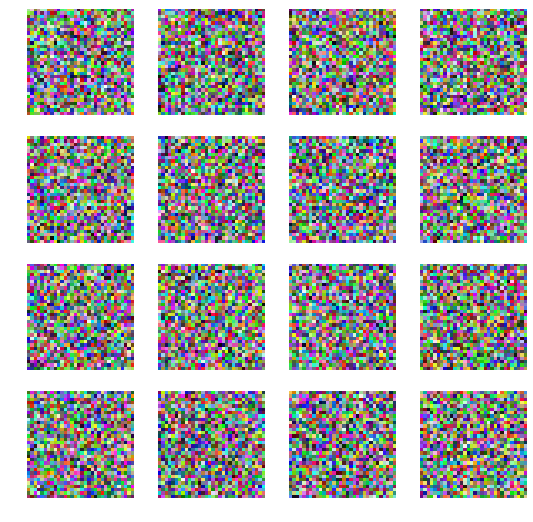

In [58]:
// Example of `showImages` with random uniform tensor.
showImages(Tensor<Float>(randomUniform: [16, 32, 32, 3]))

# 5. Training

In [0]:
let dimZ: Int = 128
let bottomWidth: Int = 4
let nFeatures: Int = 256
let batchSize: Int = 64
let nIteration: Int = 50000
var nDisUpdates: Int = 5
var interval: Int = 2
let totalBatchCount: Int = 0

In [65]:
var nEpoch: Int = 50000 / (50000 / batchSize)
print("Num epoch = \(nEpoch)")
var toralIter: Int = nEpoch * 50000 / batchSize
print("num iteration = \(totalIter)")

Num epoch = 64


In [0]:
let lr: Float = 0.0002
let beta1: Float = 0.0
let beta2: Float = 0.9
let decay: Float = lr / Float(totalIter)

In [0]:
var gen = Generator32<Float>()
var optGen = Adam(for: gen, learningRate: lr, beta1: beta1, beta2: beta2)
var dis = Discriminator32<Float>()
var optDis = Adam(for: dis, learningRate: lr, beta1: beta1, beta2: beta2)

In [0]:
let testVec = sampleVector(16, dimZ)
let generated = [Tensor<Float>]()

In [0]:
let cifarDataset = loadCIFAR10()

In [0]:
for epoch in 1...nEpoch {
    Context.local.learningPhase = .training
    
    var trainGenLoss: Float = 0.0
    var trainDisLoss: Float = 0.0
    var trainBatchCount: Int = 0
    
    let trainingShuffled = cifarDataset.training.shuffled(sampleCount: 50000, randomSeed: Int64(epoch))
    
    for batch in trainingShuffled.batched(batchSize) {
        var (_, real) = (batch.label, batch.data)
        if real.shape[0] < batchSize {
            continue
        }
        
        // Perturb real images
        real += Tensor<Float>(randomUniform: real.shape) / 128.0
        
        optGen.learningRate = lr - decay * Float(totalBatchCount)
        optGen.learningRate = lr - decay * Float(totalBatchCount)
        
        // Update Generator
        let z1 = sampleVector(batchSize, dimZ)
        for i in 1...nDisUpdates {
            let genGrad = gen.gradient { gen -> Tensor<Float> in 
                let fake = gen(z1)
                let loss = lossHingeGen(dis(fake))
                trainGenLoss += loss.scalarized() / 5.0
                return loss
            }
            optGen.update(&gen.allDifferentiableVariables, along: genGrad)
        }

        let z2 = sampleVector(batchSize, dimZ)
        let disGrad = dis.gradient { dis -> Tensor<Float> in
            let (disFake, disReal) = (dis(gen(z2)), dis(real))
            let loss = lossHingeDis(disFake, disReal)
            trainDisLoss += loss.scalarized()
            return loss
        }
        optDis.update(&dis.allDifferentiableVariables, along: disGrad)
        
        trainBatchCount += 1
        totalBatchCount += 1
        if trainBatchCount % 50 == 0 {
            print("Epoch: \(epoch), batch count: \(trainBatchCount) | gen loss: \(trainGenLoss / Float(trainBatchCount)), dis loss: \(trainDisLoss / Float(trainBatchCount))")
        }
    }
    
    print("Epoch: \(epoch) | gen loss: \(trainGenLoss / Float(trainBatchCount)), dis loss: \(trainDisLoss / Float(trainBatchCount))")
    
    Context.local.learningPhase = .inference
    let testImage = gen(testVec)
    showImages((testImage + 1.0) / 2.0, labels: nil, filename: "epoch-\(epoch).jpg")
}

Epoch: 1, batch count: 50 | gen loss: 0.06589808, dis loss: 2.0147438
Epoch: 1, batch count: 100 | gen loss: 0.03609131, dis loss: 2.013005
Epoch: 1, batch count: 150 | gen loss: 0.025281403, dis loss: 2.0107248
Epoch: 1, batch count: 200 | gen loss: 0.019812867, dis loss: 2.0091674
Epoch: 1, batch count: 250 | gen loss: 0.018613337, dis loss: 2.0065944
Epoch: 1, batch count: 300 | gen loss: 0.030252263, dis loss: 1.9803135
Epoch: 1, batch count: 350 | gen loss: 0.05961635, dis loss: 1.9276191
Epoch: 1, batch count: 400 | gen loss: 0.10944054, dis loss: 1.8663617
Epoch: 1, batch count: 450 | gen loss: 0.12974572, dis loss: 1.8366189
Epoch: 1, batch count: 500 | gen loss: 0.17586406, dis loss: 1.7700448
Epoch: 1, batch count: 550 | gen loss: 0.21383466, dis loss: 1.724776
Epoch: 1, batch count: 600 | gen loss: 0.24307744, dis loss: 1.6852081
Epoch: 1, batch count: 650 | gen loss: 0.28557983, dis loss: 1.635536
Epoch: 1, batch count: 700 | gen loss: 0.30814958, dis loss: 1.604199
Epoch: 